In [1]:
import sys
import numpy as np
from uncertainties import ufloat, unumpy
import uncertainties
import scipy
import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

sys.path.append("..")

from hists.parameters import beamEnergies, synchrotronBeamEnergiesMap
from hist_loader import HistLoader
from sigma_over_e import SigmaOverEComputations, fitSigmaOverE, SigmaOverEPlotElement, plotSigmaOverMean, sigmaOverE_fitFunction, plotSCAsEllipse
from ntupleReaders.clue_ntuple_reader import ClueNtupleReader
#from fit import HistogramEstimates

2023-06-15 17:38:43.969996: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 17:38:44.093435: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-gpu2/lib/python3.10/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND thi

In [2]:
reader = ClueNtupleReader("v40", "cmssw", "data") # sim_proton_v46_patchMIP
loader = HistLoader(reader.histStore)

In [3]:
comp_sigma_e = SigmaOverEComputations(sigmaWindow=(1, 2.5))

In [4]:
sigma_e_results = comp_sigma_e.compute({beamEnergy : loader.getClue3DProjected(reader.datatype, beamEnergy) for beamEnergy in beamEnergies}, multiprocess=True)

2023-06-15 17:38:50.280294: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1278] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-06-15 17:38:50.281303: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1278] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-06-15 17:38:50.281606: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1278] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-06-15 17:38:50.283801: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1278] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-06-15 17:38:50.284082: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1278] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-06-15 17:38:50.285078: E tensorflow/compiler/xla/stream_executor/cuda/cuda_drive

In [5]:
sigma_e_results

{20: SigmaMuResult(mu=18.1422611436889+/-0.014209098971152651, sigma=0.9608344008953835+/-0.011710675155106457, fitResult=<zfit.minimizers.fitresult.FitResult object at 0x7ffa4abe3910>, fitQuality='good'),
 30: SigmaMuResult(mu=27.620724523044107+/-0.016998602636887013, sigma=1.1737040152382485+/-0.014001423623331342, fitResult=<zfit.minimizers.fitresult.FitResult object at 0x7ffa4ac049d0>, fitQuality='good'),
 50: SigmaMuResult(mu=47.32228232249589+/-0.012831893127106727, sigma=1.5726818004368284+/-0.010702078949268739, fitResult=<zfit.minimizers.fitresult.FitResult object at 0x7ffa4abe2b00>, fitQuality='good'),
 80: SigmaMuResult(mu=77.09975830899467+/-0.017316131753774073, sigma=2.0325892894753257+/-0.014417524919175004, fitResult=<zfit.minimizers.fitresult.FitResult object at 0x7ffa4ac04970>, fitQuality='good'),
 100: SigmaMuResult(mu=97.04767863936972+/-0.028565346070357017, sigma=2.3901268481637414+/-0.0230190623924165, fitResult=<zfit.minimizers.fitresult.FitResult object at 0x7

In [6]:
beamEnergies_s = np.array(list(synchrotronBeamEnergiesMap.values()))
mu_vals = np.array([res.mu.nominal_value for res in sigma_e_results.values()])
sigma_vals = np.array([res.sigma.nominal_value for res in sigma_e_results.values()])

In [7]:
def fitFct(x, *a):
    #return a*np.log(beamEnergy) + b
    return a[0] * x**(a[1]) + a[2] 
popt, pcov = scipy.optimize.curve_fit(fitFct, xdata=beamEnergies_s, ydata=mu_vals/beamEnergies_s, p0=[1, -0.5, 0],
                                      maxfev=10**5)
popt

array([-0.59127367, -0.54769765,  1.01810674])

Text(0, 1, '$\\frac{<E^{trackster}>}{E^{beam}}$')

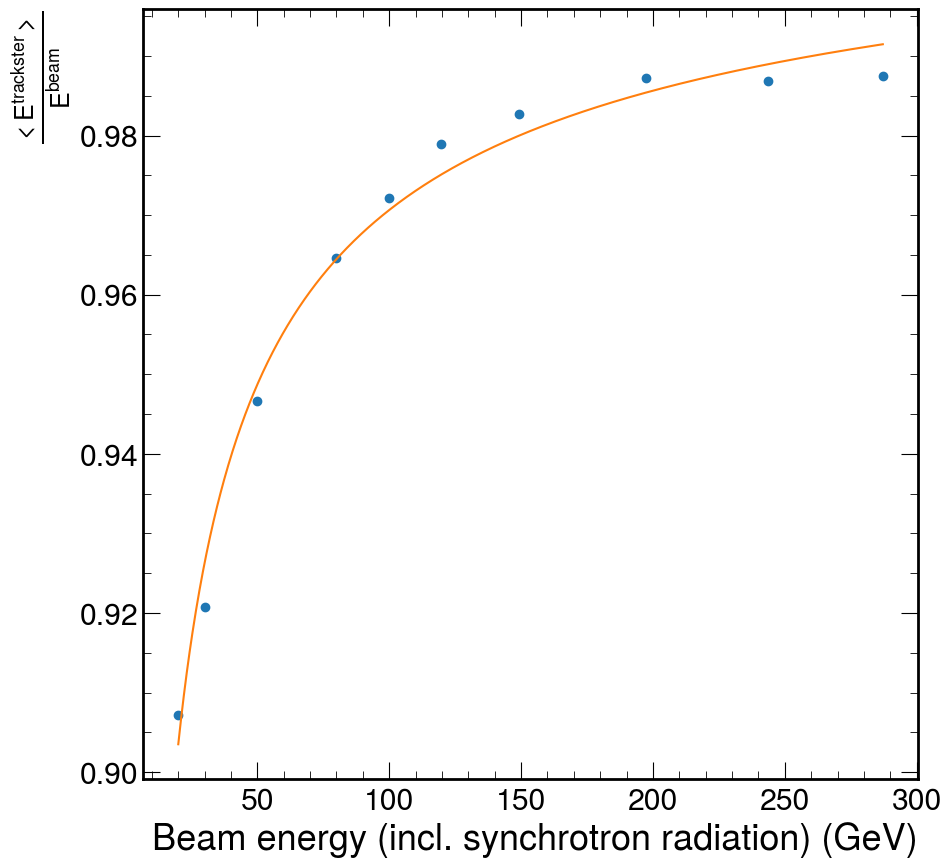

In [8]:
plt.plot(beamEnergies_s, mu_vals/beamEnergies_s, "o")
x_fct = np.linspace(beamEnergies_s[0], beamEnergies_s[-1], 1000)
plt.plot(x_fct, [fitFct(x, *popt) for x in x_fct], "-")
interp = scipy.interpolate.CubicSpline(beamEnergies_s, mu_vals/beamEnergies_s)
#plt.plot(x_fct, [interp(x) for x in x_fct], "-")
plt.xlabel("Beam energy (incl. synchrotron radiation) (GeV)")
plt.ylabel(r"$\frac{<E^{trackster}>}{E^{beam}}$")

In [9]:
beamEnergies_s, mu_vals/beamEnergies_s

(array([ 20.  ,  30.  ,  49.99,  79.93,  99.83, 119.65, 149.14, 197.32,
        243.61, 287.18]),
 array([0.90711306, 0.92069082, 0.94663497, 0.964591  , 0.97212941,
        0.97897577, 0.98273407, 0.98727282, 0.98684505, 0.98746277]))

array([-0.5132909 , -0.51232703,  1.01987132])

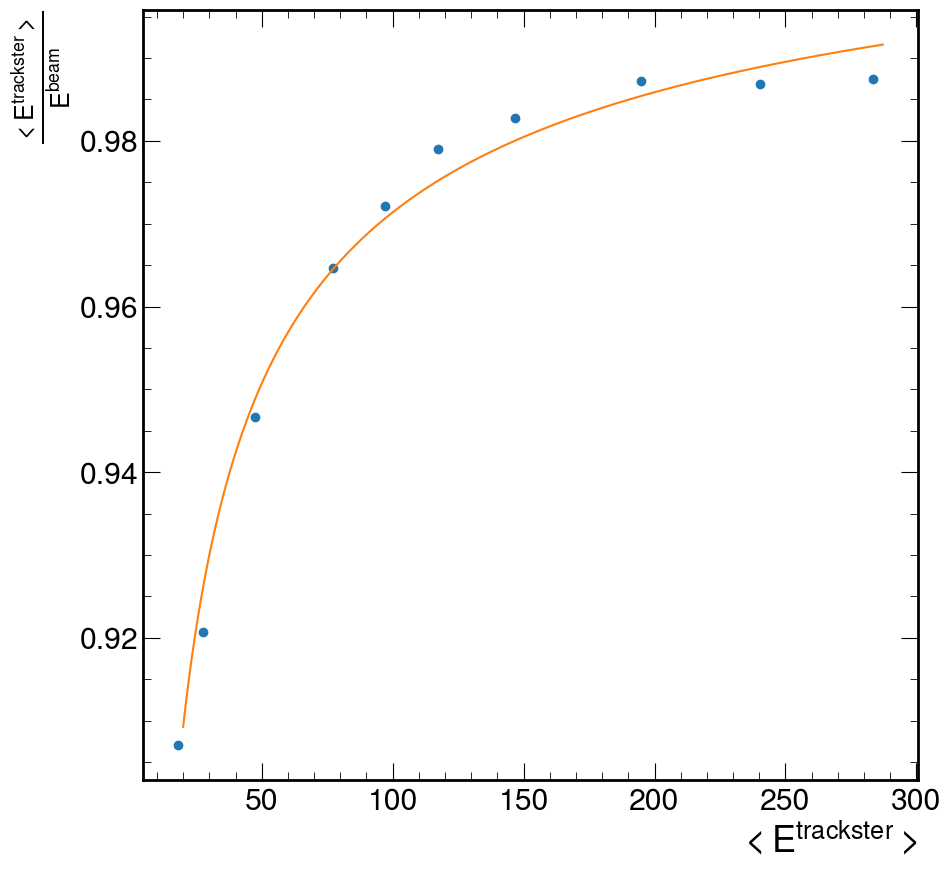

In [10]:
plt.plot(mu_vals, mu_vals/beamEnergies_s, "o")
x_fct = np.linspace(beamEnergies_s[0], beamEnergies_s[-1], 1000)
popt, pcov = scipy.optimize.curve_fit(fitFct, xdata=mu_vals, ydata=mu_vals/beamEnergies_s, p0=[1, -0.5, 0],
                                      maxfev=10**5)
plt.plot(x_fct, [fitFct(x, *popt) for x in x_fct], "-")
plt.xlabel("$<E^{trackster}>$")
plt.ylabel(r"$\frac{<E^{trackster}>}{E^{beam}}$")
popt

In [11]:
plt.plot(beamEnergies_s, [g(beamEnergy_s, mu_val) for beamEnergy_s, mu_val in zip(beamEnergies_s, mu_vals)], "o-")

NameError: name 'g' is not defined

In [ ]:
loader.getClue3DProjected(reader.datatype, 50)

Hist(Regular(2000, 0, 350, name='clus3D_energy', label='3D cluster energy (GeV)'), storage=Double()) # Sum: 59086.0

In [ ]:
popt, pcov = scipy.optimize.curve_fit(fitFct, xdata=beamEnergies_s, ydata=sigma_vals/beamEnergies_s, p0=[1, -0.5, 0],
                                      maxfev=10**5)
popt

array([ 0.20210001, -0.50211124,  0.00155485])

Text(0, 1, 'Sigma')

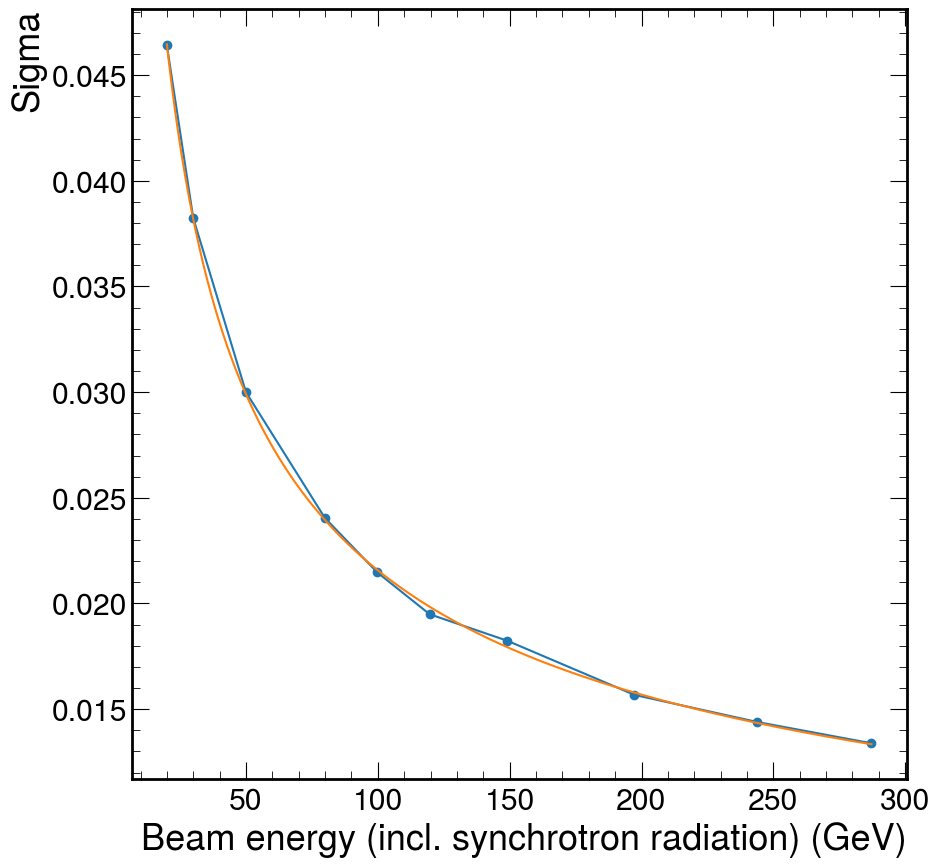

In [ ]:
plt.plot(beamEnergies_s, sigma_vals/beamEnergies_s, "o-")
x_fct = np.linspace(beamEnergies_s[0], beamEnergies_s[-1], 1000)
plt.plot(x_fct, [fitFct(x, *popt) for x in x_fct], "-")
plt.xlabel("Beam energy (incl. synchrotron radiation) (GeV)")
plt.ylabel(r"Sigma")